In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec, KeyedVectors


STEP-1: Load Dataset

In [3]:
df = pd.read_csv("C:/Users/Malathi M/OneDrive/Documents/MDTE25/guvi final project/Main project/news.tsv.zip", sep="\t")
print(df.head())

  News ID Category         Topic  \
0  N10000   sports        soccer   
1  N10001     news  newspolitics   
2  N10002     news        newsus   
3  N10003     news  newspolitics   
4  N10004     news     newsworld   

                                            Headline  \
0  Predicting Atlanta United's lineup against Col...   
1  Mitch McConnell: DC statehood push is 'full bo...   
2            Home In North Highlands Damaged By Fire   
3  Meghan McCain blames 'liberal media' and 'thir...   
4                            Today in History: Aug 1   

                                           News body  \
0  Only FIVE internationals allowed, count em, FI...   
1  WASHINGTON -- Senate Majority Leader Mitch McC...   
2  NORTH HIGHLANDS (CBS13)   Fire damaged a home ...   
3  Meghan McCain is speaking out after a journali...   
4  1714: George I becomes King Georg Ludwig, Elec...   

                                Title entity  \
0  {"Atlanta United's": 'Atlanta United FC'}   
1            

In [ ]:
list(df.columns)

['News ID',
 'Category',
 'Topic',
 'Headline',
 'News body',
 'Title entity',
 'Entity content']

In [ ]:
df["Category"].value_counts()

Category
sports           30557
news             26689
finance          10571
lifestyle         7405
autos             5494
travel            5381
foodanddrink      5286
video             4968
tv                3981
health            3799
weather           3298
music             2547
movies            1996
entertainment     1487
kids               299
europe               2
northamerica         1
adexperience         1
Name: count, dtype: int64

In [ ]:
df.isnull().sum()

News ID            0
Category           0
Topic              0
Headline           0
News body         58
Title entity       0
Entity content     0
dtype: int64

In [ ]:
# Fill NaN values to avoid errors
df['Headline'] = df.get('Headline', '').fillna('').astype(str)
df['News body'] = df.get('News body', '').fillna('').astype(str)

In [ ]:
df.isnull().sum()

News ID           0
Category          0
Topic             0
Headline          0
News body         0
Title entity      0
Entity content    0
dtype: int64

In [ ]:
# Take only 50% of the data to reduce computation
df = df.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [ ]:
df.shape

(56881, 7)

STEP-2: Combine Features (X = Headline + News body)

In [ ]:
# Combine Headline + News body
df['text'] = (df['Headline'].str.strip() + ' ' + df['News body'].str.strip()).str.strip()
df['text'] = df['text'].fillna('')

# Feature and target
X = df["text"]
y = df["Category"]

STEP-3: Text Cleaning

In [ ]:
for i in range(5):
    print("TEXT:", X.iloc[i])
    print("CATEGORY:", y.iloc[i])
    print("-" * 50)


TEXT: Stars who came out Find out how these celebs revealed their sexual and gender identities to the world. Love is love. Wonderwall.com is taking a look at all the ways the stars have told the world about their sexual and gender identities... starting with rapper Lil Nas X. Fresh off his massive hit "Old Town Road," Lil Nas X came out as gay at the end of Pride month on June 30, 2019. While posting a link to his new song "C7osure," the rapper tweeted, "Some of y'all already know, some of y'all don't care, some of y'all not [going to f  with me] no more. But before this month ends I want y'all to listen closely to c7osure." He added a rainbow emoji. In the song, Nas sings of living a "more authentic life." He later shared a video of his EP's album artwork, zooming in on a rainbow projected on a building. "I thought I made it obvious," he later tweeted. Many in the entertainment world applauded his decision to come out. Keep reading for more... In February 2019, Tony Award winner Ben P

STEP-3: Text Cleaning

In [ ]:
import string
import re
def clean_text(text):

    if pd.isna(text):
        return ""
    
    text = str(text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # Remove emojis
    text = text.encode("ascii", "ignore").decode()

    # Replace punctuation with space
    text = text.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df["clean_text"] = df["text"].apply(clean_text)
df["clean_text"].head()

0    stars who came out find out how these celebs r...
1    19 ice cream pies you ll want to make all summ...
2    mixed used development will bring variety to d...
3    paul manafort seemed headed to rikers then the...
4    sean shelby s shoes what s next for junior dos...
Name: clean_text, dtype: object

STEP-4: Tokenization + Stopword Removal

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens


[nltk_data] Downloading package punkt to C:\Users\Malathi
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Malathi
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Apply tokenization

In [ ]:
df["tokens"] = df["clean_text"].apply(tokenize_and_remove_stopwords)

In [ ]:
corpus = df["clean_text"].tolist()
tokens_list = df["tokens"].tolist()


STEP 5: Label Encoding (Target)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])

# Save encoder
with open("category_labelencoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(df[["Category", "label"]].head())

        Category  label
0  entertainment      2
1   foodanddrink      4
2        finance      3
3           news     10
4         sports     11


vectorization
STEP-6: Word Embedding 1 → BAG OF WORDS (BoW)

In [ ]:
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(corpus)


In [ ]:
with open("bow_vectorizer.pkl", "wb") as f:
    pickle.dump(bow_vectorizer, f)


STEP-7: Word Embedding 2 → TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)


In [ ]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)


STEP-8: Word Embedding 3 → WORD2VEC (Custom Trained)

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=corpus,
    vector_size=50,   # smaller embedding → faster
    window=3,
    min_count=2,
    workers=2,
    sg=0              # CBOW = low compute
)



Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

create document vector

In [ ]:
import numpy as np

def document_vector(tokens, model):
    tokens = [w for w in tokens if w in model.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[tokens], axis=0)

X_w2v = np.array([document_vector(doc, w2v_model) for doc in corpus])


In [ ]:
# Save Word2Vec model
with open("word2vec_model.pkl", "wb") as f:
    pickle.dump(w2v_model, f)

# Save document vectors and labels
#with open("X_w2v.pkl", "wb") as f:
#    pickle.dump(X_w2v, f)

#with open("y_labels.pkl", "wb") as f:
 #   pickle.dump(labels, f)


STEP-9: Word Embedding 4 → PRETRAINED EMBEDDING
Example: Glove

In [ ]:
import numpy as np
import pickle

embedding_dict = {}
with open("glove.6B.100d.txt", 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector

print("Total words loaded:", len(embedding_dict))


Total words loaded: 400000


In [ ]:
with open("glove_embeddings.pkl", "wb") as f:
    pickle.dump(embedding_dict, f)


Convert Text to Embedding Sequences for DL glove

In [ ]:
from nltk.tokenize import word_tokenize

def text_to_sequence(text, embedding_dict, max_len=100, dim=100):
    tokens = word_tokenize(text.lower())
    seq = []
    for t in tokens[:max_len]:
        if t in embedding_dict:
            seq.append(embedding_dict[t])
        else:
            seq.append(np.zeros(dim))
    # Pad shorter sequences
    while len(seq) < max_len:
        seq.append(np.zeros(dim))
    return np.array(seq)

# Example: convert all articles
X_seq = np.array([text_to_sequence(doc, embedding_dict) for doc in corpus])
print("Shape of X_seq:", X_seq.shape)  # (num_samples, max_len, 100)


Shape of X_seq: (56881, 100, 100)


In [ ]:
df.shape

(56881, 11)

In [ ]:
import os
print(os.listdir())

['bow_vectorizer.pkl', 'category_labelencoder.pkl', 'classification.ipynb', 'DL.ipynb', 'glove.6B.300d.txt', 'glove.6B.300d.word2vec', 'ML.ipynb', 'NER.ipynb', 'news.tsv.zip', 'reference.docx', 'summarization.ipynb', 'tfidf_vectorizer.pkl', 'tokenizer.pkl', 'word2vec_custom.model', 'word2vec_custom.model.syn1neg.npy', 'word2vec_custom.model.wv.vectors.npy', 'word2vec_pretrained.pkl']


Classification-focused EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


2A: Category Distribution

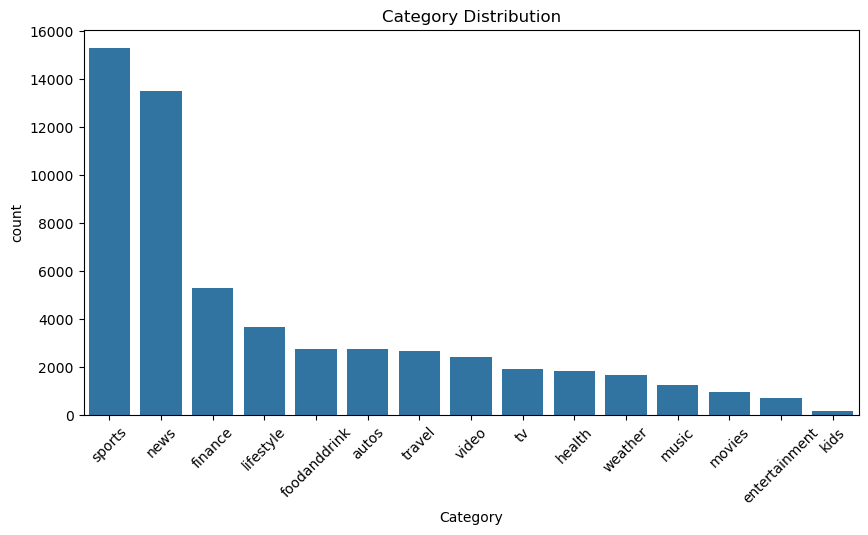

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Category", order=df["Category"].value_counts().index)
plt.title("Category Distribution")
plt.xticks(rotation=45)
plt.show()


2B: Average Word Count per Category

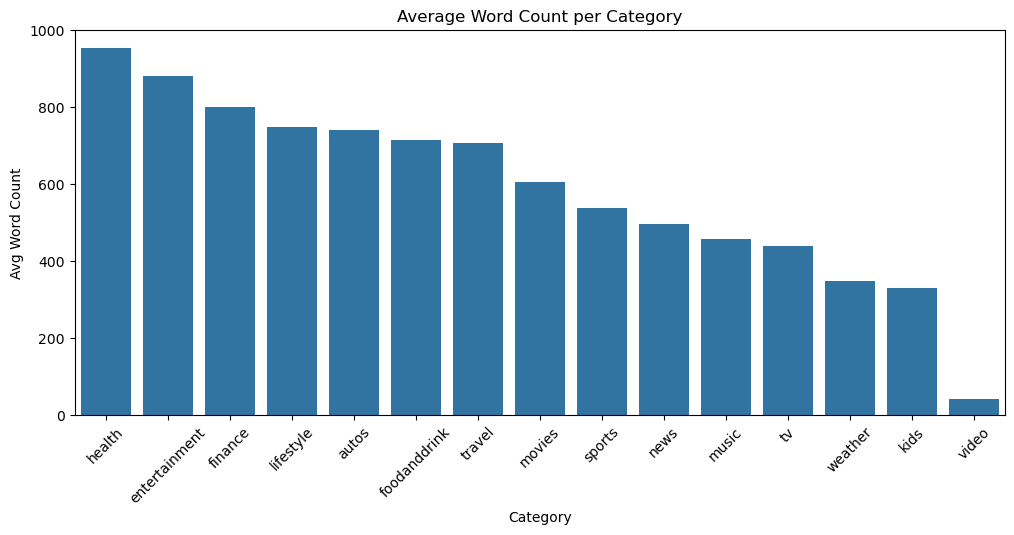

In [ ]:
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
avg_wc = df.groupby("Category")["word_count"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=avg_wc.index, y=avg_wc.values)
plt.title("Average Word Count per Category")
plt.ylabel("Avg Word Count")
plt.xticks(rotation=45)
plt.show()


2C: Word Clouds per Category

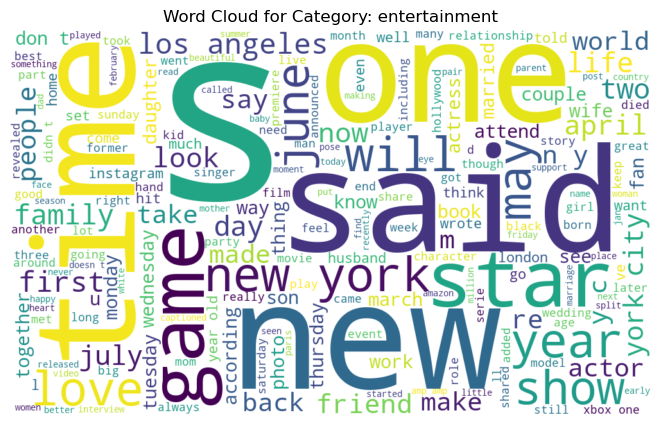

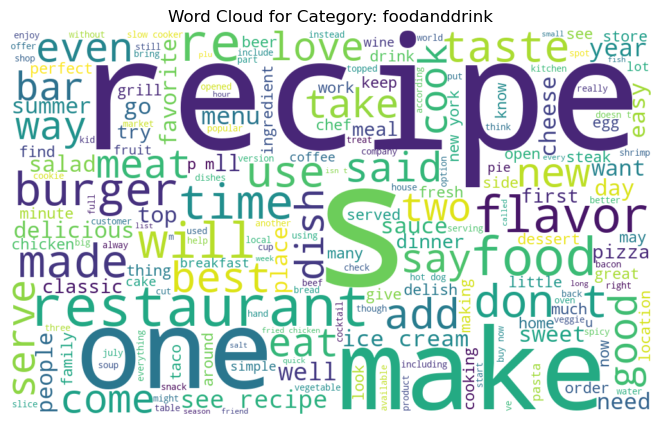

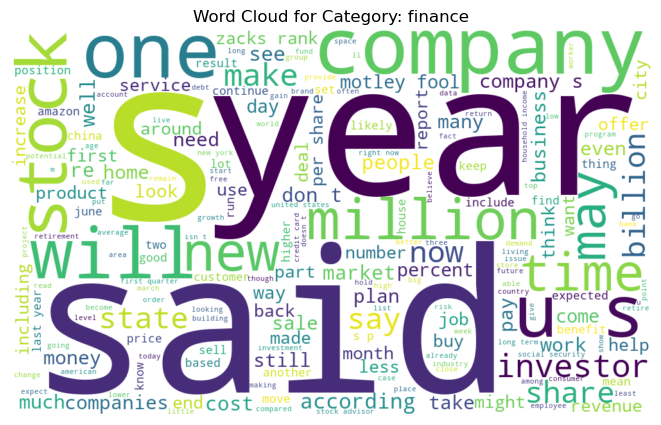

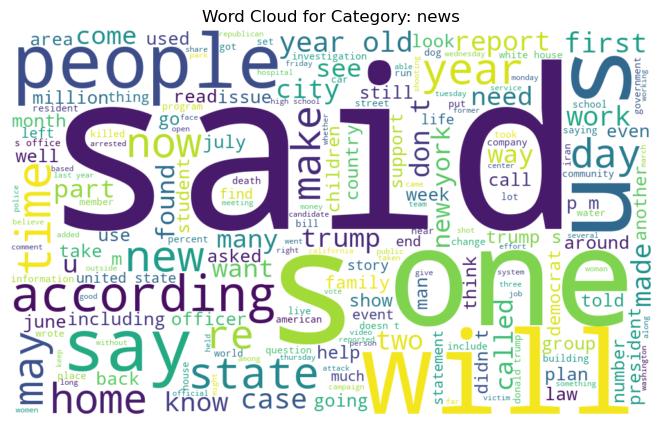

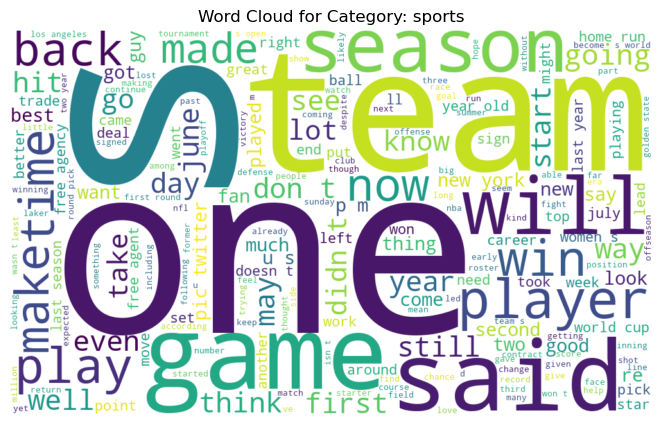

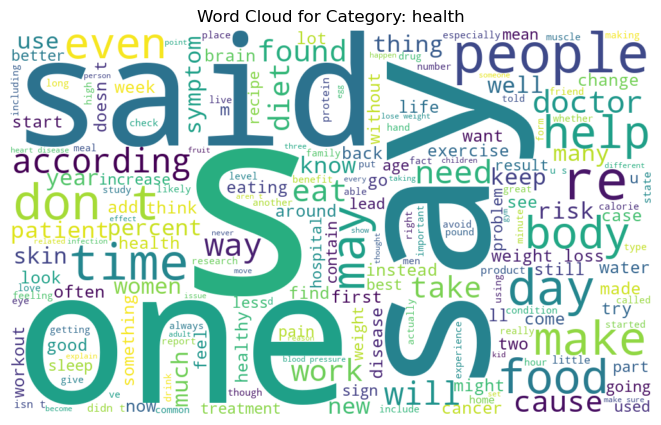

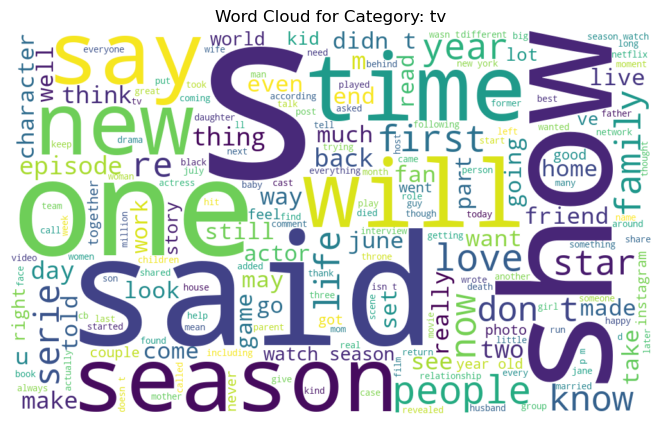

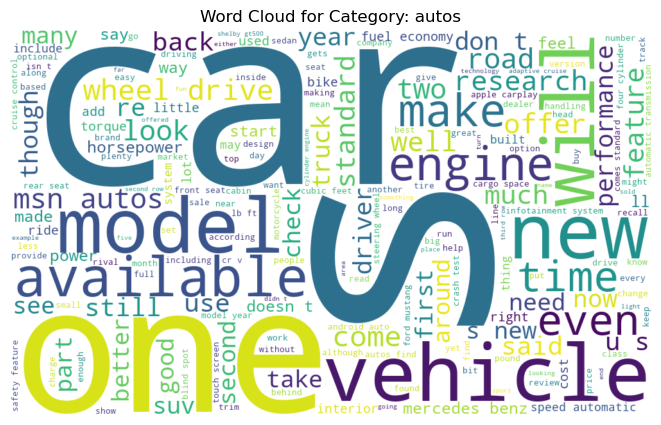

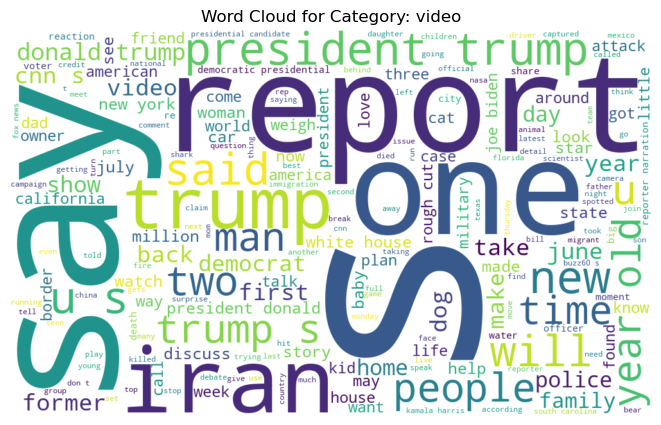

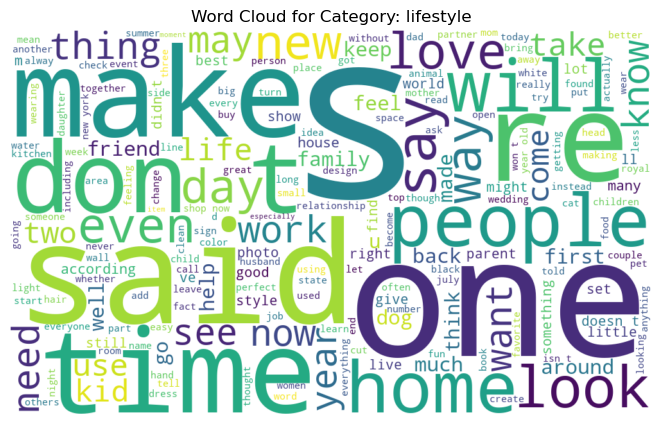

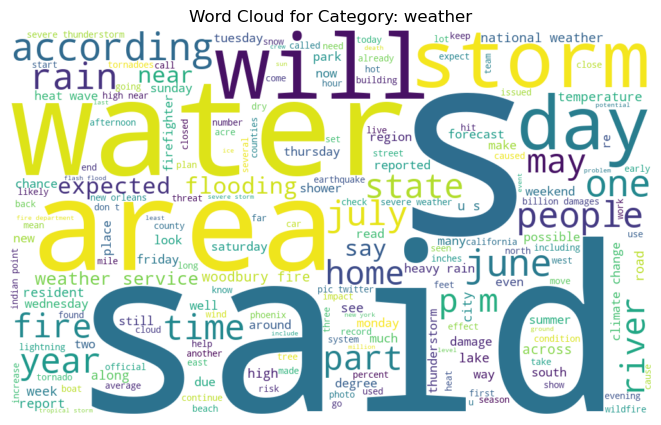

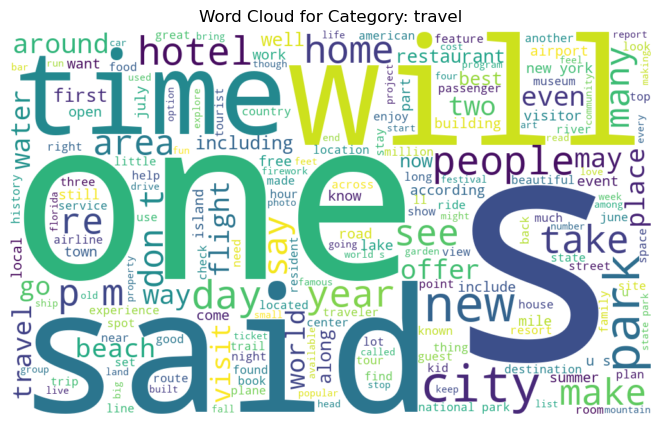

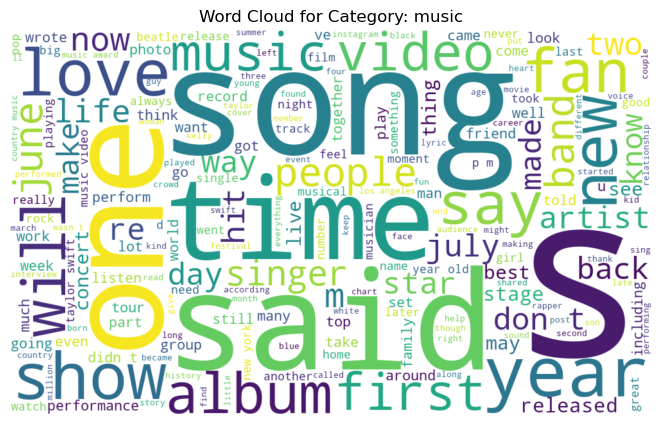

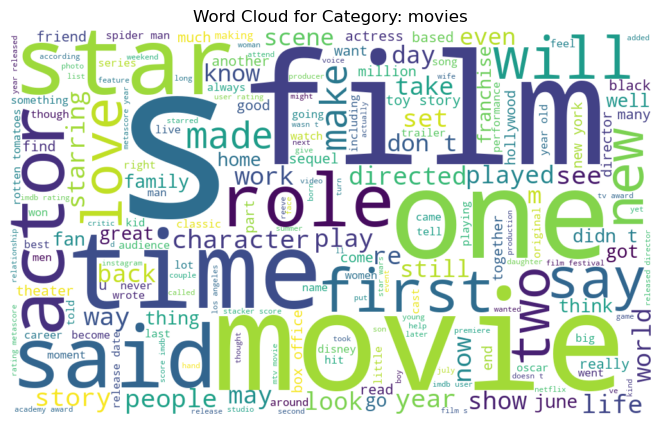

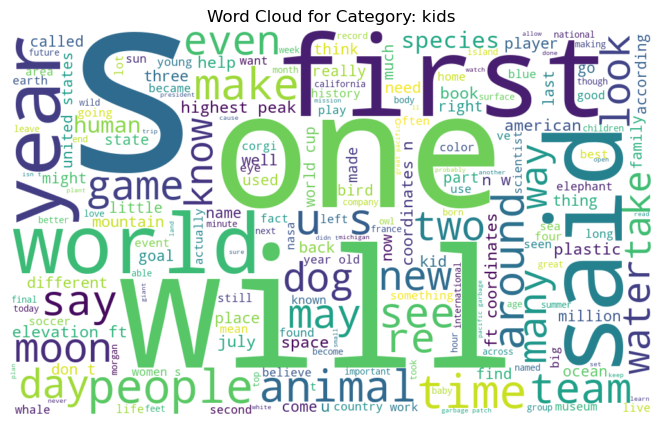

In [ ]:
categories = df["Category"].unique()

for cat in categories:
    text = " ".join(df[df["Category"] == cat]["clean_text"])
    wordcloud = WordCloud(width=1000, height=600, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Category: {cat}")
    plt.axis("off")
    plt.show()


2D: TF-IDF Top Keywords per Category

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df["clean_text"])
feature_names = tfidf.get_feature_names_out()

def get_top_tfidf_words(texts, n=10):
    matrix = tfidf.transform(texts)
    avg_tfidf = np.mean(matrix.toarray(), axis=0)
    top_indices = avg_tfidf.argsort()[-n:]
    top_words = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
    return sorted(top_words, key=lambda x: x[1], reverse=True)

for cat in categories:
    subset = df[df["Category"] == cat]["clean_text"].tolist()
    print(f"\nTop TF-IDF words for {cat}:")
    print(get_top_tfidf_words(subset))


STEP 4: Summarization-focused EDA

In [ ]:
# Assuming you have summary column: df["summary"]

#df["summary_length"] = df["summary"].apply(lambda x: len(str(x).split()))
#df["compression_ratio"] = df["summary_length"] / df["word_count"]

# Article vs Summary Length Distribution
#plt.figure(figsize=(12,5))
#sns.histplot(df["word_count"], color='blue', label='Article Length', kde=True, bins=30)
#sns.histplot(df["summary_length"], color='orange', label='Summary Length', kde=True, bins=30)
#plt.legend()
#plt.title("Article vs Summary Length Distribution")
#plt.show()

# Average Compression Ratio
#avg_ratio = df.groupby("Category")["compression_ratio"].mean()
#plt.figure(figsize=(12,5))
#sns.barplot(x=avg_ratio.index, y=avg_ratio.values)
#plt.title("Average Compression Ratio per Category")
#plt.ylabel("Avg Compression Ratio (summary/article)")
#plt.xticks(rotation=45)
#plt.show()


STEP 5: Overall Text Statistics

In [ ]:
#all_tokens = [token for sublist in df["tokens"] for token in sublist]
#vocab = set(all_tokens)
#print("Vocabulary size:", len(vocab))


TF-IDF Heatmap of Frequent Terms per Category

In [ ]:
#import seaborn as sns

#tfidf = TfidfVectorizer(max_features=50)
#X = tfidf.fit_transform(df["clean_text"])
#tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
#tfidf_df["Category"] = df["Category"]

#plt.figure(figsize=(14,6))
#sns.heatmap(tfidf_df.groupby("Category").mean(), cmap="Blues")
#plt.title("TF-IDF Heatmap of Top Terms per Category")
#plt.show()

5B: Most Frequent Unigrams and Bigrams

In [ ]:
#from collections import Counter
#from nltk.util import ngrams

# Unigrams
#unigram_counts = Counter(all_tokens)
#print("Top 10 unigrams:", unigram_counts.most_common(10))

# Bigrams
#all_bigrams = [bigram for tokens in df["tokens"] for bigram in ngrams(tokens, 2)]
#bigram_counts = Counter(all_bigrams)
#print("Top 10 bigrams:", bigram_counts.most_common(10))


MACHINE LEARNING

In [ ]:
import pandas as pd
import numpy as np
import pickle

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import Trainer, TrainingArguments

import tensorflow as tf
from tf_keras.models import Sequential
from tf_keras.layers import Dense, LSTM, Embedding, Dropout


STEP 1: Load Dataset and Preprocessed Features

In [ ]:
import pandas as pd
import numpy as np
import pickle
from gensim.models import KeyedVectors
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# For tokenization (if not already tokenized)
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to C:\Users\Malathi
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Logistic Regression Performance Comparison: BoW vs TF-IDF

In [ ]:
#from sklearn.model_selection import train_test_split
# Example using TF-IDF features
#X = X_tfidf
#y = df["label"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Step 3: Prepare DataFrame Columns

In [ ]:
print(df.columns)


Index(['News ID', 'Category', 'Topic', 'Headline', 'News body', 'Title entity',
       'Entity content', 'text', 'clean_text', 'tokens', 'label',
       'word_count'],
      dtype='object')


In [ ]:
import pickle

# Load your saved vectorizers
with open("bow_vectorizer.pkl", "rb") as f:
    bow_vectorizer = pickle.load(f)

with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

# Load Word2Vec model
with open("word2vec_model.pkl", "rb") as f:
    loaded_w2v = pickle.load(f)


In [ ]:
# Remove classes with less than 2 samples
df = df[df["Category"].map(df["Category"].value_counts()) > 1]

print(df["Category"].value_counts())


Category
sports           15272
news             13502
finance           5290
lifestyle         3675
foodanddrink      2733
autos             2733
travel            2660
video             2425
tv                1938
health            1853
weather           1680
music             1248
movies             983
entertainment      733
kids               155
Name: count, dtype: int64


In [ ]:
X = df["clean_text"]
y = df["Category"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


4. Transform Text (BoW & TF-IDF)

BoW

In [ ]:
X_train_bow = bow_vectorizer.transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


TF IDF

In [ ]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


word2vector

In [ ]:
# Truncate to the smaller length
min_len = min(len(X_w2v), len(y))
X_w2v = X_w2v[:min_len]
y = y[:min_len]

print(len(X_w2v))  # should now equal len(y)
print(len(y))


56880
56880


In [ ]:
from sklearn.model_selection import train_test_split

X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42
)


5. Build & Train LOGESTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_bow = LogisticRegression(max_iter=500)
log_reg_tfidf = LogisticRegression(max_iter=500)
log_reg_w2v = LogisticRegression(max_iter=500)


Train

In [ ]:
log_reg_bow.fit(X_train_bow, y_train)
log_reg_tfidf.fit(X_train_tfidf, y_train)
log_reg_w2v.fit(X_train_w2v, y_train)


c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

6. Evaluate Both Models

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# Predictions
y_pred_bow = log_reg_bow.predict(X_test_bow)
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)
y_pred_w2v = log_reg_w2v.predict(X_test_w2v)

# Accuracy
acc_bow = accuracy_score(y_test, y_pred_bow)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
acc_w2v = accuracy_score(y_test, y_pred_w2v)

# Classification reports
print("===== Logistic Regression + BoW =====")
print(classification_report(y_test, y_pred_bow))

print("===== Logistic Regression + TF-IDF =====")
print(classification_report(y_test, y_pred_tfidf))

print("===== Logistic Regression + Word2Vec =====")
print(classification_report(y_test, y_pred_w2v))

# Confusion matrices
cm_bow = confusion_matrix(y_test, y_pred_bow)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
cm_w2v = confusion_matrix(y_test, y_pred_w2v)

print("\nConfusion Matrix (BoW):\n", cm_bow)
print("\nConfusion Matrix (TF-IDF):\n", cm_tfidf)
print("\nConfusion Matrix (Word2Vec):\n", cm_w2v)


===== Logistic Regression + BoW =====
               precision    recall  f1-score   support

        autos       0.06      0.03      0.04       551
entertainment       0.02      0.01      0.01       151
      finance       0.10      0.07      0.08      1060
 foodanddrink       0.04      0.02      0.03       585
       health       0.02      0.01      0.01       388
         kids       0.00      0.00      0.00        27
    lifestyle       0.05      0.03      0.04       711
       movies       0.02      0.01      0.01       178
        music       0.02      0.01      0.01       251
         news       0.23      0.31      0.27      2667
       sports       0.27      0.42      0.32      3077
       travel       0.04      0.02      0.03       529
           tv       0.03      0.01      0.02       371
        video       0.05      0.02      0.03       475
      weather       0.02      0.01      0.01       355

     accuracy                           0.20     11376
    macro avg       0.06 

c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3

               precision    recall  f1-score   support

        autos       0.00      0.00      0.00       551
entertainment       0.00      0.00      0.00       151
      finance       0.19      0.01      0.02      1060
 foodanddrink       0.00      0.00      0.00       585
       health       0.00      0.00      0.00       388
         kids       0.00      0.00      0.00        27
    lifestyle       0.00      0.00      0.00       711
       movies       0.00      0.00      0.00       178
        music       0.00      0.00      0.00       251
         news       0.23      0.40      0.29      2667
       sports       0.27      0.60      0.37      3077
       travel       0.00      0.00      0.00       529
           tv       0.00      0.00      0.00       371
        video       0.00      0.00      0.00       475
      weather       0.00      0.00      0.00       355

     accuracy                           0.26     11376
    macro avg       0.05      0.07      0.05     11376
 weighte

8. Compare Results

In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["LogReg + BoW", "LogReg + TF-IDF","LogReg + W2V"],
    "Accuracy": [acc_bow, acc_tfidf, acc_w2v]
})

print(comparison_df)


             Model  Accuracy
0     LogReg + BoW  0.199367
1  LogReg + TF-IDF  0.255450
2     LogReg + W2V  0.282788


DECISION TREE

5. Train Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_bow = DecisionTreeClassifier(random_state=42)
dt_tfidf = DecisionTreeClassifier(random_state=42)
dt_w2v = DecisionTreeClassifier(random_state=42)


dt_bow.fit(X_train_bow, y_train)
dt_tfidf.fit(X_train_tfidf, y_train)
dt_w2v.fit(X_train_w2v, y_train)

DecisionTreeClassifier(random_state=42)

Evaluation (Accuracy, Precision, Recall, F1, Confusion Matrix)

In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# Predictions
y_pred_bow = dt_bow.predict(X_test_bow)
y_pred_tfidf = dt_tfidf.predict(X_test_tfidf)
y_pred_w2v = dt_w2v.predict(X_test_w2v)

# Accuracy
dt_acc_bow = accuracy_score(y_test, y_pred_bow)
dt_acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
dt_acc_w2v =  accuracy_score(y_test, y_pred_w2v)

# Reports
print("===== Decision Tree + BoW =====")
print(classification_report(y_test, y_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bow))

print("\n===== Decision Tree + TF-IDF =====")
print(classification_report(y_test, y_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tfidf))

print("\n===== Decision Tree + w2v =====")
print(classification_report(y_test, y_pred_w2v))
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred_w2v))


===== Decision Tree + BoW =====
               precision    recall  f1-score   support

        autos       0.07      0.06      0.06       551
entertainment       0.02      0.01      0.02       151
      finance       0.10      0.09      0.10      1060
 foodanddrink       0.06      0.05      0.05       585
       health       0.03      0.03      0.03       388
         kids       0.00      0.00      0.00        27
    lifestyle       0.05      0.05      0.05       711
       movies       0.01      0.01      0.01       178
        music       0.02      0.02      0.02       251
         news       0.23      0.26      0.24      2667
       sports       0.28      0.30      0.29      3077
       travel       0.04      0.03      0.04       529
           tv       0.02      0.02      0.02       371
        video       0.04      0.04      0.04       475
      weather       0.03      0.03      0.03       355

     accuracy                           0.17     11376
    macro avg       0.07      0

Performance Comparison Table

In [ ]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["Deci_Tree + BoW", "Deci_Tree + TF-IDF","Desi_Tree + w2v"],
    "Accuracy": [dt_acc_bow, dt_acc_tfidf,dt_acc_w2v]
})

print(comparison)


                Model  Accuracy
0     Deci_Tree + BoW  0.165260
1  Deci_Tree + TF-IDF  0.164030
2     Desi_Tree + w2v  0.160689


RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# --- Step 1: Initialize Random Forest models ---
rf_bow = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)

# --- Step 2: Train ---
rf_bow.fit(X_train_bow, y_train)
rf_tfidf.fit(X_train_tfidf, y_train)
rf_w2v.fit(X_train_w2v, y_train)

RandomForestClassifier(random_state=42)

In [ ]:

# --- Step 3: Predict ---
y_pred_bow = rf_bow.predict(X_test_bow)
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
y_pred_w2v = rf_w2v.predict(X_test_w2v)

# --- Step 4: Accuracy ---
rf_acc_bow = accuracy_score(y_test, y_pred_bow)
rf_acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
rf_acc_w2v = accuracy_score(y_test, y_pred_w2v)

# --- Step 5: Classification Reports ---
print("===== Random Forest + BoW =====")
print(classification_report(y_test, y_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bow))

print("\n===== Random Forest + TF-IDF =====")
print(classification_report(y_test, y_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tfidf))

print("\n===== Random Forest + Word2Vec =====")
print(classification_report(y_test, y_pred_w2v))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_w2v))


===== Random Forest + BoW =====


c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

        autos       0.05      0.00      0.00       551
entertainment       0.00      0.00      0.00       151
      finance       0.11      0.00      0.01      1060
 foodanddrink       0.07      0.00      0.01       585
       health       0.00      0.00      0.00       388
         kids       0.00      0.00      0.00        27
    lifestyle       0.09      0.00      0.01       711
       movies       0.00      0.00      0.00       178
        music       0.06      0.00      0.01       251
         news       0.24      0.35      0.29      2667
       sports       0.27      0.64      0.38      3077
       travel       0.00      0.00      0.00       529
           tv       0.00      0.00      0.00       371
        video       0.00      0.00      0.00       475
      weather       0.00      0.00      0.00       355

     accuracy                           0.26     11376
    macro avg       0.06      0.07      0.05     11376
 weighte

c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

        autos       0.05      0.00      0.00       551
entertainment       0.00      0.00      0.00       151
      finance       0.15      0.00      0.01      1060
 foodanddrink       0.05      0.00      0.00       585
       health       0.00      0.00      0.00       388
         kids       0.00      0.00      0.00        27
    lifestyle       0.12      0.01      0.01       711
       movies       0.00      0.00      0.00       178
        music       0.06      0.00      0.01       251
         news       0.24      0.35      0.28      2667
       sports       0.27      0.64      0.38      3077
       travel       0.00      0.00      0.00       529
           tv       0.00      0.00      0.00       371
        video       0.00      0.00      0.00       475
      weather       0.00      0.00      0.00       355

     accuracy                           0.26     11376
    macro avg       0.06      0.07      0.05     11376
 weighte

c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- Step 6: Compare Accuracies ---
comparison = pd.DataFrame({
    "Model": ["RandomForest + BoW", "RandomForest + TF-IDF", "RandomForest + Word2Vec"],
    "Accuracy": [rf_acc_bow, rf_acc_tfidf, rf_acc_w2v]
})

print("\nAccuracy Comparison:\n", comparison)


Accuracy Comparison:
                      Model  Accuracy
0       RandomForest + BoW  0.257032
1    RandomForest + TF-IDF  0.257032
2  RandomForest + Word2Vec  0.266526


7. Save the best Trained Models

In [ ]:
#with open("log_reg_bow.pkl", "wb") as f:
 #   pickle.dump(log_reg_bow, f)

#with open("log_reg_tfidf.pkl", "wb") as f:
 #   pickle.dump(log_reg_tfidf, f)


DEEP LEARNING

In [ ]:
!pip install gensim tensorflow


In [ ]:
texts = df["clean_text"].astype(str)
labels = df["Category"]

STEP 3: Tokenize Text → Sequences

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

X_seq = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)

# Save tokenizer
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"))


emberding matrix

STEP 4: Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)


STEP 5: Load Word2Vec Model

In [ ]:
import pickle
import numpy as np

with open("glove_embedding.pkl", "rb") as f:
    glove_dict = pickle.load(f)

with open("word2vec_model.pkl", "rb") as f:
    word2vec = pickle.load(f)


In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("word2vec_model.pkl")

embedding_dim = w2v_model.vector_size
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


STEP 6: Build Embedding Matrix

In [ ]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.uniform(-0.05, 0.05, embedding_dim)


In [ ]:
vocab_size = len(word_index) + 1


label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
 # y = your labels # Assuming y_train and y_test are already split
y_train_encoded = le.transform(y_train) 
y_test_encoded = le.transform(y_test)

In [ ]:
# Example tokenized sequences
print(X_train.shape)  # should be (num_samples, MAX_LEN)


(45504, 100)


FULL RNN + Word2Vec MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_rnn = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    
    SimpleRNN(64, return_sequences=False),
    Dropout(0.2),

    Dense(32, activation="relu"),
    Dropout(0.2),

    Dense(len(le.classes_), activation="softmax")
])

model_rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_rnn.summary()


c:\Users\Malathi M\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    10,727,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,727,850 (40.92 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,727,850 (40.92 MB)

Train RNN

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[es]
)


Epoch 1/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.2768 - loss: 2.2346 - val_accuracy: 0.3108 - val_loss: 2.1577
Epoch 2/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.3174 - loss: 2.1416 - val_accuracy: 0.3339 - val_loss: 2.0831
Epoch 3/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3373 - loss: 2.0921 - val_accuracy: 0.3413 - val_loss: 2.0582
Epoch 4/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3501 - loss: 2.0641 - val_accuracy: 0.3522 - val_loss: 2.0294
Epoch 5/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3537 - loss: 2.0449 - val_accuracy: 0.3595 - val_loss: 2.0100
Epoch 6/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.3633 - loss: 2.0264 - val_accuracy: 0.3730 - val_loss: 1.9968
Epoch 7/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3724 - loss: 2.0119 - val_accuracy: 0.3863 - val_loss: 1.9789
Epoch 8/10
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3757 - loss:

Evaluate RNN

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_rnn = np.argmax(model_rnn.predict(X_test), axis=1)

rnn_acc = accuracy_score(y_test_encoded, y_pred_rnn)

print("RNN Accuracy:", accuracy_score(y_test_encoded , y_pred_rnn))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_rnn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded , y_pred_rnn))


356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RNN Accuracy: 0.3768459915611814

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.26      0.40       547
           1       0.00      0.00      0.00       147
           2       0.81      0.32      0.46      1058
           3       0.00      0.00      0.00       546
           4       0.00      0.00      0.00       371
           5       0.00      0.00      0.00        31
           6       0.49      0.14      0.21       735
           7       0.40      0.05      0.09       197
           8       0.00      0.00      0.00       249
           9       0.38      0.43      0.40      2700
          10       0.34      0.83      0.48      3054
          11       0.00      0.00      0.00       532
          12       0.42      0.05      0.10       388
          13       0.00      0.00      0.00       485
          14       0.00      0.00      0.00       336

    accuracy                       

c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


FULL LSTM + Word2Vec MODE

In [ ]:
MAX_LEN = 100
embedding_dim = 100
LSTM_units = 64
batch_size = 64


In [ ]:

from tensorflow.keras.layers import LSTM
embedding_dim = embedding_matrix.shape[1]  # Automatically take from your matrix

model_lstm = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,      # <-- must match embedding_matrix
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    
    Dense(32, activation="relu"),
    Dropout(0.2),

    Dense(len(le.classes_), activation="softmax")
])


In [ ]:
from tensorflow.keras.layers import LSTM

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_lstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    10,727,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,727,850 (40.92 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,727,850 (40.92 MB)

Train LSTM

In [ ]:
history_lstm = model_lstm.fit(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=5,
    batch_size=16,
    callbacks=[es]
)


Epoch 1/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 74s 30ms/step - accuracy: 0.2718 - loss: 2.2331 - val_accuracy: 0.2794 - val_loss: 2.1939
Epoch 2/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 67s 29ms/step - accuracy: 0.2851 - loss: 2.1954 - val_accuracy: 0.2835 - val_loss: 2.1521
Epoch 3/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 65s 29ms/step - accuracy: 0.3048 - loss: 2.1623 - val_accuracy: 0.3244 - val_loss: 2.1155
Epoch 4/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - accuracy: 0.3225 - loss: 2.1250 - val_accuracy: 0.3325 - val_loss: 2.0779


Evaluate LSTM

In [ ]:
# LSTM evaluation
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)

lstm_acc = accuracy_score(y_test_encoded, y_pred_lstm)

print("LSTM Accuracy:", lstm_acc)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_lstm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_lstm))


356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
LSTM Accuracy: 0.2807665260196906

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       547
           1       0.00      0.00      0.00       147
           2       0.84      0.11      0.20      1058
           3       0.00      0.00      0.00       546
           4       0.00      0.00      0.00       371
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00       735
           7       0.36      0.05      0.09       197
           8       0.00      0.00      0.00       249
           9       0.33      0.02      0.03      2700
          10       0.27      0.99      0.43      3054
          11       0.00      0.00      0.00       532
          12       0.00      0.00      0.00       388
          13       0.00      0.00      0.00       485
          14       0.00      0.00      0.00       336

    accuracy                      

c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BiLSTM + Word2Vector

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional

model_bilstm = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    
    # BiLSTM layer
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    
    Dense(32, activation="relu"),
    Dropout(0.2),
    
    Dense(len(le.classes_), activation="softmax")
])

model_bilstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_bilstm.summary()


c:\Users\Malathi M\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │    10,727,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,727,850 (40.92 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,727,850 (40.92 MB)

In [ ]:
history_bilstm = model_bilstm.fit(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=5,
    batch_size=16,
    callbacks=[es]
)

Epoch 1/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 145s 62ms/step - accuracy: 0.2796 - loss: 2.2279 - val_accuracy: 0.2950 - val_loss: 2.1536
Epoch 2/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 140s 61ms/step - accuracy: 0.2960 - loss: 2.1431 - val_accuracy: 0.3218 - val_loss: 2.0858
Epoch 3/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 148s 65ms/step - accuracy: 0.3215 - loss: 2.0948 - val_accuracy: 0.3315 - val_loss: 2.0433
Epoch 4/5
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 188s 59ms/step - accuracy: 0.3398 - loss: 2.0442 - val_accuracy: 0.3493 - val_loss: 2.0058


In [ ]:
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test), axis=1)

# Accuracy
bilstm_acc = accuracy_score(y_test_encoded, y_pred_bilstm)

# Print results
print("BiLSTM Accuracy:", bilstm_acc)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_bilstm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_bilstm))


356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
BiLSTM Accuracy: 0.29377637130801687

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       547
           1       0.00      0.00      0.00       147
           2       0.86      0.11      0.19      1058
           3       0.00      0.00      0.00       546
           4       0.00      0.00      0.00       371
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00       735
           7       0.00      0.00      0.00       197
           8       0.00      0.00      0.00       249
           9       0.26      0.80      0.40      2700
          10       0.35      0.35      0.35      3054
          11       0.00      0.00      0.00       532
          12       0.00      0.00      0.00       388
          13       0.00      0.00      0.00       485
          14       0.00      0.00      0.00       336

    accuracy                  

c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Malathi M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd

comparison_dl = pd.DataFrame({
    "Model": ["RNN + Word2Vec", "LSTM + Word2Vec","BILSTM + Word2Vec"],
    "Accuracy": [rnn_acc,lstm_acc,bilstm_acc]
})

print(comparison_dl)


               Model  Accuracy
0     RNN + Word2Vec  0.376846
1    LSTM + Word2Vec  0.280767
2  BILSTM + Word2Vec  0.293776


BERT PRETAINED MODEL

In [ ]:
import transformers
print(transformers.__version__)


4.57.3


In [ ]:
comparison = pd.DataFrame({
    "Model": ["LogReg + BoW", "LogReg + TF-IDF", "LogReg + W2V",
              "DecisionTree + BoW", "DecisionTree + TF-IDF", "DecisionTree + W2V",
              "RandomForest + BoW", "RandomForest + TF-IDF", "RandomForest + W2V",
              "RNN + W2V","LSTM + W2V"],
    "Accuracy": [acc_bow, acc_tfidf, acc_w2v,
                 dt_acc_bow, dt_acc_tfidf, dt_acc_w2v,
                 rf_acc_bow, rf_acc_tfidf, rf_acc_w2v,
                 rnn_acc,lstm_acc]
})

print(comparison)